# Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sma
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold


# Set random seed for consistency
np.random.seed(42)

# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
telco = pd.read_csv(r'C:/Users/ev00246/OneDrive - University of Surrey/Dissertation/dataset/Churn.csv')

In [3]:
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

In [4]:
# Check the various attributes of data like shape (no:of rows and cols), Column names, datatypes
telco.shape

(7043, 21)

In [5]:
telco.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [6]:
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# SeniorCitizen is actually a categorical variable, so lets convert it to category
telco['SeniorCitizen'] = telco['SeniorCitizen'].astype('category')

In [8]:
# Total Charges should be numeric. Let's convert it to numerical data type
telco.TotalCharges = pd.to_numeric(telco.TotalCharges, errors='coerce')

In [9]:
# Check the descriptive statistics of numeric variables
telco.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [10]:
telco.info(verbose = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   object  
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   object  
 4   Dependents        7043 non-null   object  
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   object  
 7   MultipleLines     7043 non-null   object  
 8   InternetService   7043 non-null   object  
 9   OnlineSecurity    7043 non-null   object  
 10  OnlineBackup      7043 non-null   object  
 11  DeviceProtection  7043 non-null   object  
 12  TechSupport       7043 non-null   object  
 13  StreamingTV       7043 non-null   object  
 14  StreamingMovies   7043 non-null   object  
 15  Contract          7043 non-null   object  
 16  PaperlessBilling  7043 n

In [11]:
100*telco['Churn'].value_counts()/len(telco['Churn']) # Data is imbalanced, ratio = 73:27

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

In [12]:
telco.isna().sum() # checking for missing values

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
# droppinng rows with missing values 
telco.dropna(how = 'any', inplace = True)

In [14]:
telco.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   object  
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   object  
 4   Dependents        7032 non-null   object  
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   object  
 7   MultipleLines     7032 non-null   object  
 8   InternetService   7032 non-null   object  
 9   OnlineSecurity    7032 non-null   object  
 10  OnlineBackup      7032 non-null   object  
 11  DeviceProtection  7032 non-null   object  
 12  TechSupport       7032 non-null   object  
 13  StreamingTV       7032 non-null   object  
 14  StreamingMovies   7032 non-null   object  
 15  Contract          7032 non-null   object  
 16  PaperlessBilling  7032 non-nu

Univariate Analysis

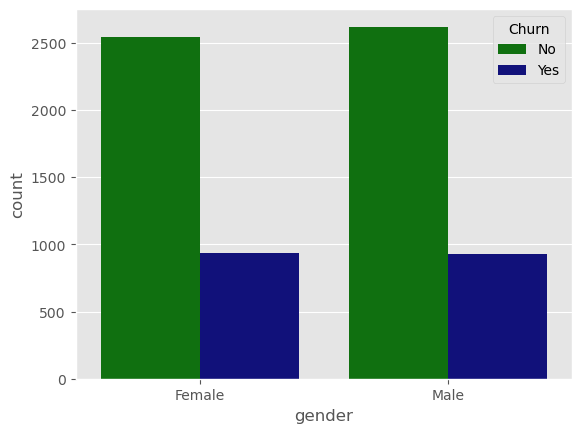

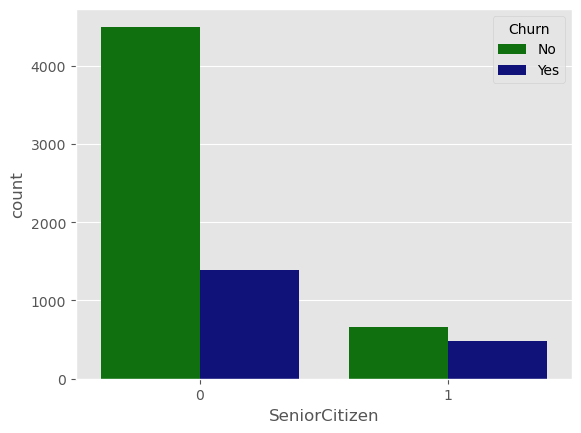

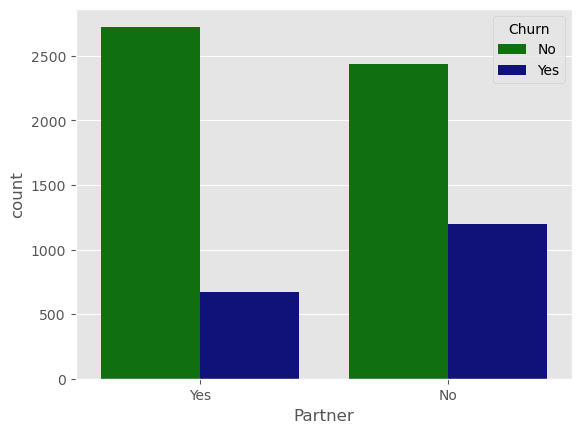

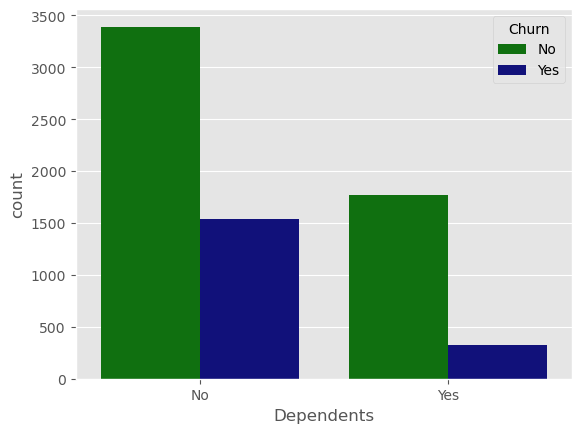

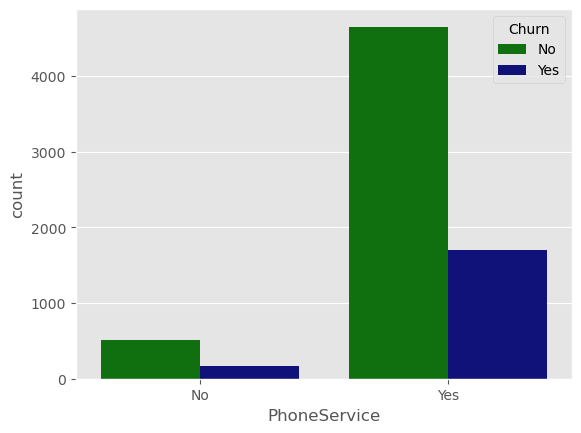

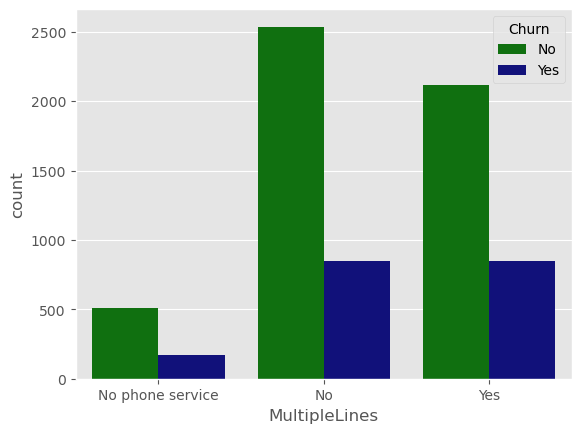

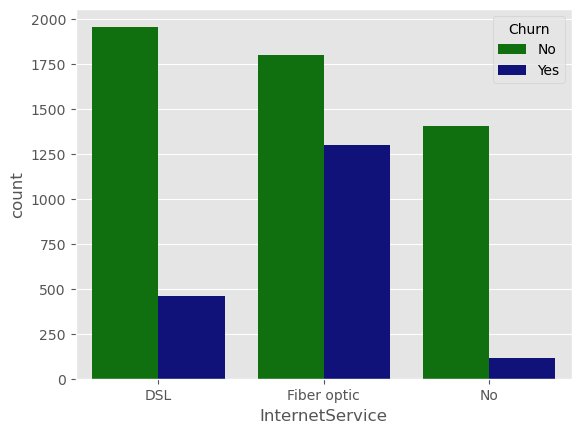

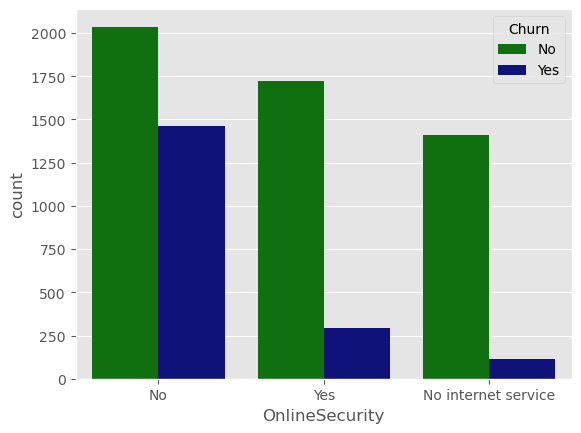

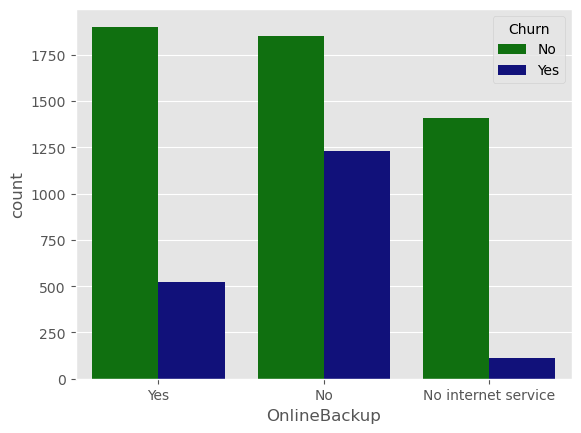

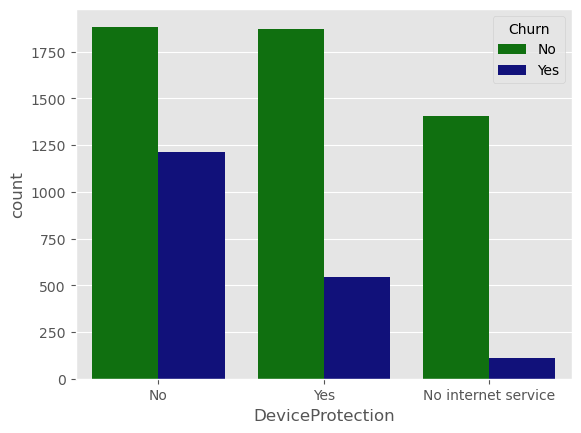

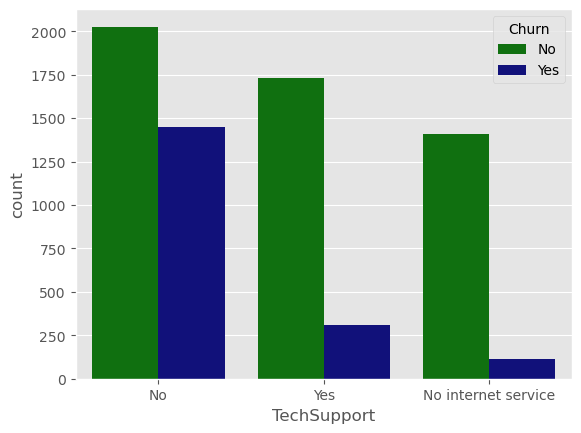

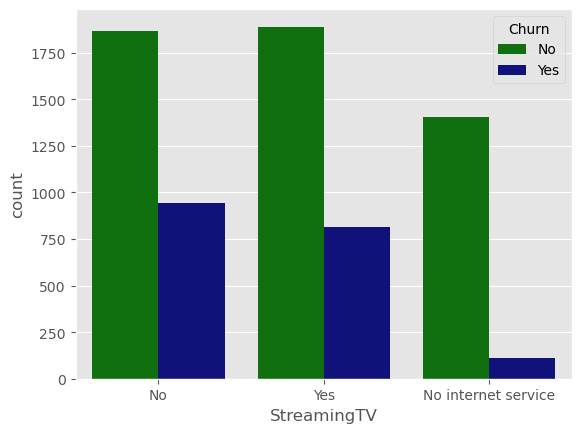

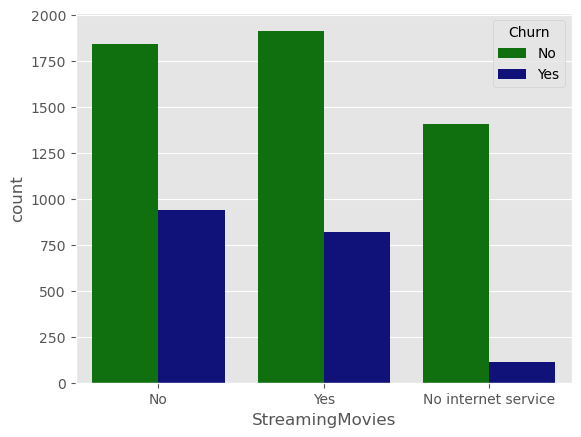

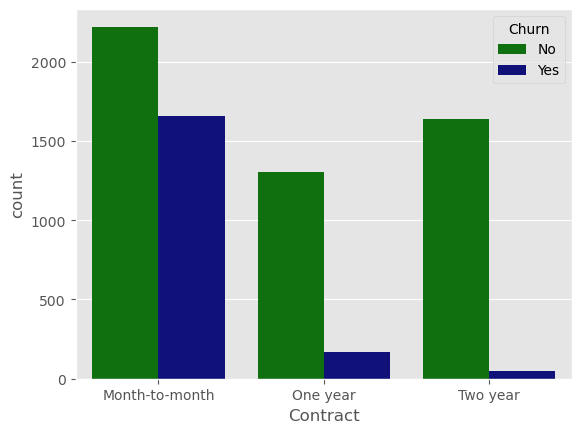

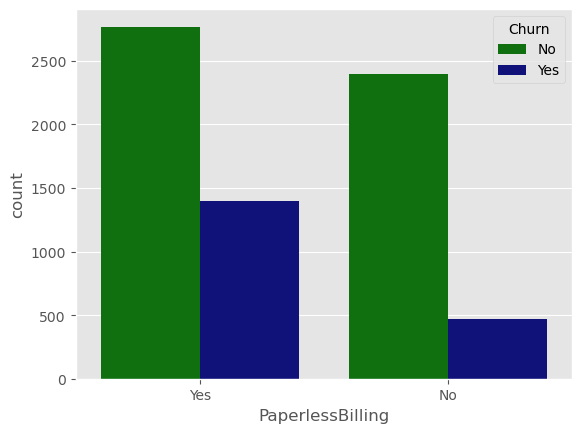

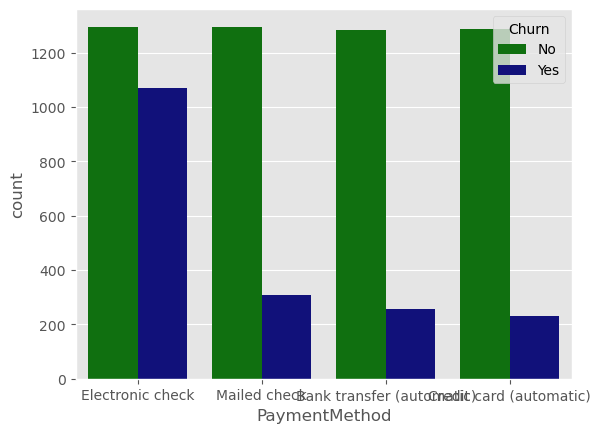

In [15]:
for i, predictor in enumerate(telco.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges','customerID', 'tenure'])):
    plt.figure(i)
    sns.countplot(data=telco, x=predictor, hue='Churn', palette=['green', 'darkblue'])
    plt.show()

In [16]:
#drop column customerID
telco.drop(columns= ['customerID'], axis=1, inplace=True)

In [17]:
# Convert the target variable 'Churn' into a binary numeric variable i.e. Yes=1 , No = 0
telco['Churn'] = np.where(telco.Churn == 'Yes',1,0)

In [18]:
telco_dummies = pd.get_dummies(telco)
telco_dummies = telco_dummies.astype(int)
telco_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29,29,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56,1889,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53,108,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42,1840,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70,151,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


Text(0.5, 1.0, 'churn by monthly charges')

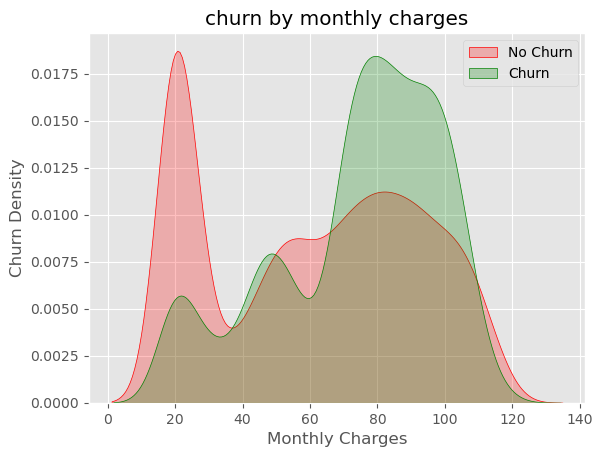

In [19]:
# churn by monthly charges
Mth = sns.kdeplot(telco_dummies.MonthlyCharges[(telco_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(telco_dummies.MonthlyCharges[(telco_dummies["Churn"] == 1) ],
                ax =Mth, color="Green", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Churn Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('churn by monthly charges')

In [20]:
telco_1 = telco_dummies

In [21]:
telco_1.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29,29,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56,1889,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53,108,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42,1840,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70,151,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


# Models to be used:
- Decision Tree
- Random Forest
- XGBoost
- Logistic Regression

In [22]:
# Build models and evaluate

models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,        # Limit the depth of the tree
        min_samples_split=10, # Minimum samples required to split an internal node
        min_samples_leaf=5    # Minimum samples required to be at a leaf node
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,    # Number of trees in the forest
        max_depth=10,        # Maximum depth of each tree
        min_samples_split=10, # Minimum samples required to split an internal node
        min_samples_leaf=5,   # Minimum samples required to be at a leaf node
        n_jobs=-1            # Use all available cores
    ),
    
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,       # Maximum number of iterations
        solver='liblinear',  # Solver for optimization (use 'liblinear' for smaller datasets)
        penalty='l2',        # Regularization term
        C=1.0,               # Inverse of regularization strength
        n_jobs=-1            # Use all available cores (works with 'liblinear' solver)
    ),
    
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        n_estimators=100,    # Number of boosting rounds
        max_depth=10,        # Maximum depth of a tree
        learning_rate=0.1,   # Step size shrinkage used to prevent overfitting
        subsample=0.8,       # Subsample ratio of the training instances
        colsample_bytree=0.8,# Subsample ratio of columns when constructing each tree
        n_jobs=-1            # Use all available cores
    )
}

# Correlation-based feature selection (CFS):

In [23]:
runtime_cfs_start = time.time() # starting time
correlations = telco_1.corr()['Churn'].abs()
selected_features = correlations[correlations > 0.3].index.tolist()
selected_features.remove('Churn')
runtime_cfs_end = time.time() # ending time
X_cfs = telco_1[selected_features]
runtime_cfs = (runtime_cfs_end - runtime_cfs_start) * 1000  # Runtime in milliseconds

In [24]:
print(f"Runtime for CFS: {runtime_cfs:.2f} ms")

Runtime for CFS: 46.48 ms


In [25]:
X_train_cfs, X_test_cfs, y_train, y_test = train_test_split(X_cfs, telco_1['Churn'], test_size=0.3, random_state=42)

smote_enn = SMOTE(random_state=42)
X_train_cfs_resampled, y_train_resampled = smote_enn.fit_resample(X_train_cfs, y_train)

results_cfs = {}

for model_name, model in models.items():
    model.fit(X_train_cfs_resampled, y_train_resampled)
    y_pred = model.predict(X_test_cfs)
    results_cfs[model_name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Balanced Accuracy': accuracy_score(y_test, y_pred)
    }

ranked_features = correlations[selected_features].sort_values(ascending=False)
print(f"Ranked Features: \n{ranked_features}")

Ranked Features: 
Contract_Month-to-month           0.404565
tenure                            0.354049
OnlineSecurity_No                 0.342235
TechSupport_No                    0.336877
InternetService_Fiber optic       0.307463
Contract_Two year                 0.301552
PaymentMethod_Electronic check    0.301455
Name: Churn, dtype: float64


In [26]:
# Display the results
for model_name, metrics in results_cfs.items():
    print(f"Results for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    print("\n")

Results for Decision Tree:
Precision: 0.490
Recall: 0.749
F1 Score: 0.592
ROC AUC: 0.733
Balanced Accuracy: 0.726


Results for Random Forest:
Precision: 0.491
Recall: 0.754
F1 Score: 0.595
ROC AUC: 0.736
Balanced Accuracy: 0.727


Results for Logistic Regression:
Precision: 0.497
Recall: 0.791
F1 Score: 0.611
ROC AUC: 0.751
Balanced Accuracy: 0.732


Results for XGBoost:
Precision: 0.479
Recall: 0.715
F1 Score: 0.574
ROC AUC: 0.717
Balanced Accuracy: 0.718




## Quality curves

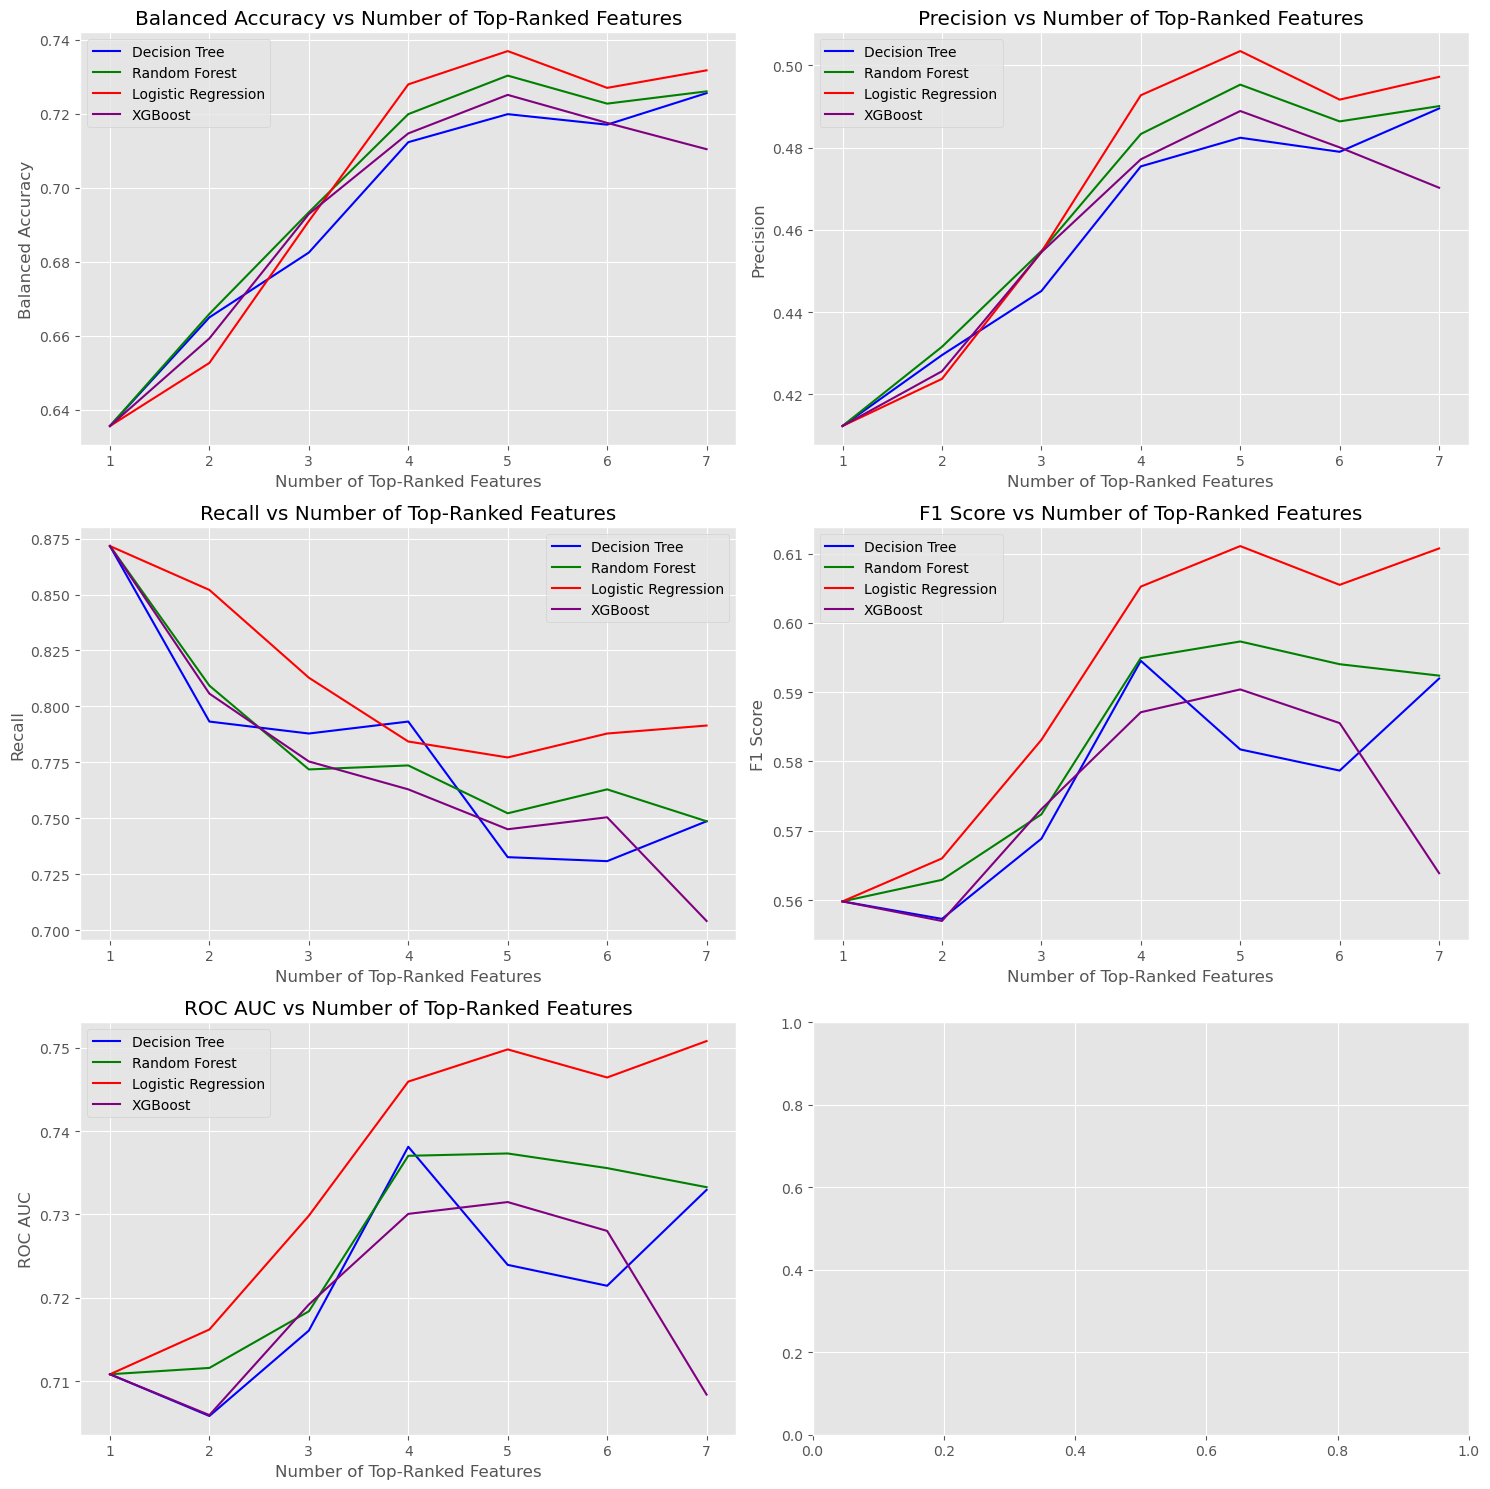

In [27]:
# Define the metrics and colors
metrics = ['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['blue', 'green', 'red', 'purple']
n_features = len(ranked_features)

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over the metrics to plot each one in a subplot
for i, metric in enumerate(metrics[:]):
    ax = axes[i]
    for model_name, model in models.items():
        metric_values = []
        for j in range(1, n_features + 1):
            top_features = ranked_features.index[:j]
            X_train_top = X_train_cfs_resampled[top_features]
            X_test_top = X_test_cfs[top_features]
            model.fit(X_train_top, y_train_resampled)
            y_pred_top = model.predict(X_test_top)
            if metric == 'Balanced Accuracy':
                score = accuracy_score(y_test, y_pred_top)
            elif metric == 'Precision':
                score = precision_score(y_test, y_pred_top)
            elif metric == 'Recall':
                score = recall_score(y_test, y_pred_top)
            elif metric == 'F1 Score':
                score = f1_score(y_test, y_pred_top)
            elif metric == 'ROC AUC':
                score = roc_auc_score(y_test, y_pred_top)    
            metric_values.append(score)
        ax.plot(range(1, n_features + 1), metric_values, label=model_name, color=colors[list(models.keys()).index(model_name)])
    ax.set_title(f"{metric} vs Number of Top-Ranked Features")
    ax.set_xlabel("Number of Top-Ranked Features")
    ax.set_ylabel(f"{metric}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

# LASSO Feature selection


In [28]:
X = telco_1.drop(columns=['Churn'])
y = telco_1['Churn']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [29]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [30]:
names=telco_1.drop("Churn", axis=1).columns

In [31]:
# calling the model with the best parameter
runtime_lasso_start = time.time() # starting time

lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

In [32]:
# Subsetting the features which has more than 0.001 importance.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

runtime_lasso_end = time.time() # ending time

runtime_lasso = (runtime_lasso_end - runtime_lasso_start) * 1000  # Runtime in milliseconds

Selected Feature Columns: ['tenure' 'MonthlyCharges' 'gender_Female' 'SeniorCitizen_0' 'Partner_No'
 'Dependents_No' 'PhoneService_No' 'MultipleLines_No' 'MultipleLines_Yes'
 'InternetService_Fiber optic' 'InternetService_No' 'OnlineSecurity_No'
 'OnlineSecurity_No internet service' 'OnlineBackup_No'
 'OnlineBackup_No internet service' 'DeviceProtection_Yes'
 'TechSupport_No' 'TechSupport_Yes' 'StreamingTV_No' 'StreamingTV_Yes'
 'StreamingMovies_No' 'StreamingMovies_Yes' 'Contract_Month-to-month'
 'Contract_One year' 'PaperlessBilling_No'
 'PaymentMethod_Bank transfer (automatic)'
 'PaymentMethod_Credit card (automatic)' 'PaymentMethod_Electronic check']


In [33]:
print(f"Runtime for Lasso feature selection: {runtime_lasso:.2f} ms")

Runtime for Lasso feature selection: 190.88 ms


In [34]:
X_lasso = X[list(feature_subset)]

In [35]:
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X_lasso, y, test_size=0.3, random_state=42)
X_train_lasso_resampled, y_train_resampled = smote_enn.fit_resample(X_train_lasso, y_train)

# Build models and evaluate
results_lasso = {}

for model_name, model in models.items():
    model.fit(X_train_lasso_resampled, y_train_resampled)
    y_pred = model.predict(X_test_lasso)
    results_lasso[model_name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Balanced Accuracy': accuracy_score(y_test, y_pred)
    }

In [36]:
# Display the results
for model_name, metrics in results_lasso.items():
    print(f"Results for {model_name}:\n")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    print("\n")

Results for Decision Tree:

Precision: 0.508
Recall: 0.599
F1 Score: 0.549
ROC AUC: 0.694
Balanced Accuracy: 0.739


Results for Random Forest:

Precision: 0.546
Recall: 0.692
F1 Score: 0.610
ROC AUC: 0.742
Balanced Accuracy: 0.765


Results for Logistic Regression:

Precision: 0.572
Recall: 0.679
F1 Score: 0.621
ROC AUC: 0.748
Balanced Accuracy: 0.780


Results for XGBoost:

Precision: 0.554
Recall: 0.578
F1 Score: 0.565
ROC AUC: 0.705
Balanced Accuracy: 0.764




# Forward stepwise selection (using BIC):

In [37]:
# Function to process a subset of features and calculate BIC
def processSubset(feature_set):
    model = sma.OLS(y, X[list(feature_set)])  # Fit the model on the selected feature set
    regr = model.fit()
    BIC = regr.bic 
    return {"model": regr, "BIC": BIC, "features": feature_set}  

In [38]:
# Function to perform forward stepwise selection based on BIC
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors + [p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) + 1, "predictors in", (toc - tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model  

In [39]:
# Initialize an empty dataframe to store the models
models_fwd = pd.DataFrame(columns=["BIC", "features", "model"])

tic = time.time()
predictors = []

# Forward stepwise selection
for i in range(1, len(X.columns) + 1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc - tic), "seconds.")

Processed  46 models on 1 predictors in 0.06829667091369629 seconds.
Processed  45 models on 2 predictors in 0.04923582077026367 seconds.
Processed  44 models on 3 predictors in 0.07929539680480957 seconds.
Processed  43 models on 4 predictors in 0.08127880096435547 seconds.
Processed  42 models on 5 predictors in 0.07779812812805176 seconds.
Processed  41 models on 6 predictors in 0.10376644134521484 seconds.
Processed  40 models on 7 predictors in 0.09793758392333984 seconds.
Processed  39 models on 8 predictors in 0.09843254089355469 seconds.
Processed  38 models on 9 predictors in 0.11571407318115234 seconds.
Processed  37 models on 10 predictors in 0.12497067451477051 seconds.
Processed  36 models on 11 predictors in 0.14484810829162598 seconds.
Processed  35 models on 12 predictors in 0.1405935287475586 seconds.
Processed  34 models on 13 predictors in 0.16082286834716797 seconds.
Processed  33 models on 14 predictors in 0.1405932903289795 seconds.
Processed  32 models on 15 pred

In [40]:
models_fwd

,BIC,features,model
1,7305.836697,[Contract_Month-to-month],<statsmodels.regression.linear_model.Regressio...
2,6825.084913,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
3,6689.341815,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
4,6551.063249,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
5,6373.696149,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
6,6314.030675,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
7,6296.268409,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
8,6280.518186,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
9,6269.253164,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...
10,6264.252837,"[Contract_Month-to-month, InternetService_Fibe...",<statsmodels.regression.linear_model.Regressio...


In [41]:
list(models_fwd.iloc[10, 1])

['Contract_Month-to-month',
 'InternetService_Fiber optic',
 'OnlineSecurity_No',
 'TotalCharges',
 'MonthlyCharges',
 'PaymentMethod_Electronic check',
 'PaperlessBilling_Yes',
 'TechSupport_No',
 'MultipleLines_No',
 'SeniorCitizen_1',
 'StreamingMovies_No']

In [42]:
runtime_forward = (toc-tic) * 1000

In [43]:
X_forward = X[list(models_fwd.iloc[10, 1])]
X_train_forward, X_test_forward, y_train, y_test = train_test_split(X_forward, y, test_size=0.3, random_state=42)
X_train_forward_resampled, y_train_resampled = smote_enn.fit_resample(X_train_forward, y_train)

In [44]:
print(f"Runtime for Forward stepwise selection: {runtime_forward:.2f} ms")

Runtime for Forward stepwise selection: 8704.37 ms


In [45]:
results_forward = {}

for model_name, model in models.items():
    model.fit(X_train_forward_resampled, y_train_resampled)
    y_pred = model.predict(X_test_forward)
    results_forward[model_name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Balanced Accuracy': accuracy_score(y_test, y_pred)
    }

In [46]:
# Display the results
for model_name, metrics in results_forward.items():
    print(f"Results for {model_name}:\n")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    print("\n")

Results for Decision Tree:

Precision: 0.460
Recall: 0.699
F1 Score: 0.555
ROC AUC: 0.701
Balanced Accuracy: 0.702


Results for Random Forest:

Precision: 0.511
Recall: 0.727
F1 Score: 0.600
ROC AUC: 0.738
Balanced Accuracy: 0.743


Results for Logistic Regression:

Precision: 0.497
Recall: 0.688
F1 Score: 0.577
ROC AUC: 0.718
Balanced Accuracy: 0.732


Results for XGBoost:

Precision: 0.493
Recall: 0.638
F1 Score: 0.556
ROC AUC: 0.700
Balanced Accuracy: 0.729




# Backward stepwise selection (using BIC):

In [47]:
# Function to perform backward stepwise selection based on BIC
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    # Test all combinations of predictors where one predictor is removed
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in", (toc - tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [48]:
# Initialize an empty dataframe to store the models
models_bwd = pd.DataFrame(columns=["BIC", "features", "model"], index=range(1, len(X.columns)))

tic = time.time()
predictors = X.columns  # Start with all predictors

# Backward stepwise selection
while len(predictors) > 1:
    models_bwd.loc[len(predictors) - 1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors) - 1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc - tic), "seconds.")

Processed  46 models on 45 predictors in 1.0665991306304932 seconds.
Processed  45 models on 44 predictors in 1.02939772605896 seconds.
Processed  44 models on 43 predictors in 1.0009899139404297 seconds.
Processed  43 models on 42 predictors in 0.944209098815918 seconds.
Processed  42 models on 41 predictors in 0.9162671566009521 seconds.
Processed  41 models on 40 predictors in 0.8910307884216309 seconds.
Processed  40 models on 39 predictors in 0.922621488571167 seconds.
Processed  39 models on 38 predictors in 0.7873101234436035 seconds.
Processed  38 models on 37 predictors in 0.7823624610900879 seconds.
Processed  37 models on 36 predictors in 0.7646725177764893 seconds.
Processed  36 models on 35 predictors in 0.7062187194824219 seconds.
Processed  35 models on 34 predictors in 0.6646761894226074 seconds.
Processed  34 models on 33 predictors in 0.5978658199310303 seconds.
Processed  33 models on 32 predictors in 0.5812482833862305 seconds.
Processed  32 models on 31 predictors 

In [49]:
models_bwd

,BIC,features,model
1,7305.836697,"(Contract_Month-to-month,)",<statsmodels.regression.linear_model.Regressio...
2,6825.084913,"(InternetService_Fiber optic, Contract_Month-t...",<statsmodels.regression.linear_model.Regressio...
3,6725.485473,"(TotalCharges, InternetService_Fiber optic, Co...",<statsmodels.regression.linear_model.Regressio...
4,6468.622333,"(TotalCharges, InternetService_DSL, InternetSe...",<statsmodels.regression.linear_model.Regressio...
5,6415.414739,"(TotalCharges, InternetService_DSL, InternetSe...",<statsmodels.regression.linear_model.Regressio...
6,6418.257874,"(TotalCharges, gender_Female, InternetService_...",<statsmodels.regression.linear_model.Regressio...
7,6397.936571,"(TotalCharges, gender_Female, gender_Male, Int...",<statsmodels.regression.linear_model.Regressio...
8,6395.439086,"(TotalCharges, gender_Female, gender_Male, Int...",<statsmodels.regression.linear_model.Regressio...
9,6387.141831,"(TotalCharges, gender_Female, gender_Male, Int...",<statsmodels.regression.linear_model.Regressio...
10,6355.732473,"(TotalCharges, gender_Female, gender_Male, Int...",<statsmodels.regression.linear_model.Regressio...


In [50]:
list(models_bwd.iloc[16, 1])

['tenure',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'MultipleLines_No',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'OnlineSecurity_No',
 'TechSupport_No',
 'StreamingTV_No',
 'StreamingMovies_No',
 'Contract_Month-to-month',
 'PaperlessBilling_No',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Mailed check']

In [51]:
runtime_backward = (toc-tic) * 1000

In [52]:
X_backward = X[list(models_bwd.iloc[16, 1])]
X_train_backward, X_test_backward, y_train, y_test = train_test_split(X_backward, y, test_size=0.3, random_state=42)
X_train_backward_resampled, y_train_resampled = smote_enn.fit_resample(X_train_backward, y_train)

In [53]:
print(f"Runtime for Backward stepwise selection: {runtime_backward:.2f} ms")

Runtime for Backward stepwise selection: 17247.03 ms


In [54]:
results_backward = {}

for model_name, model in models.items():
    model.fit(X_train_backward_resampled, y_train_resampled)
    y_pred = model.predict(X_test_backward)
    results_backward[model_name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Balanced Accuracy': accuracy_score(y_test, y_pred)
    }

In [55]:
# Display the results
for model_name, metrics in results_backward.items():
    print(f"Results for {model_name}:\n")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    print("\n")

Results for Decision Tree:

Precision: 0.518
Recall: 0.626
F1 Score: 0.567
ROC AUC: 0.708
Balanced Accuracy: 0.746


Results for Random Forest:

Precision: 0.563
Recall: 0.656
F1 Score: 0.606
ROC AUC: 0.736
Balanced Accuracy: 0.773


Results for Logistic Regression:

Precision: 0.571
Recall: 0.665
F1 Score: 0.614
ROC AUC: 0.742
Balanced Accuracy: 0.778


Results for XGBoost:

Precision: 0.587
Recall: 0.585
F1 Score: 0.586
ROC AUC: 0.718
Balanced Accuracy: 0.780




# Best Subset Selection

In [56]:
# Function to find the best model for a given number of features based on BIC
def getBest(k):
    tic = time.time()
    
    results = []
    # Loop through all combinations of k features
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest BIC
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc - tic), "seconds.")
    
    # Return the best model with BIC and the list of features used
    return best_model

In [57]:
# Initialize the dataframe to store the best models
models_best = pd.DataFrame(columns=["BIC", "features", "model"])

tic = time.time()

# Loop through different numbers of predictors (e.g., 1 to 3 predictors)
for i in range(1, 4):
    best_model = getBest(i)
    # Store the BIC, list of features, and model in the dataframe
    models_best.loc[i] = [best_model["BIC"], best_model["features"], best_model["model"]]

toc = time.time()
runtime_optimal = (toc - tic) * 1000
print("Total elapsed time:", runtime_optimal, "ms.")

Processed 46 models on 1 predictors in 0.047565460205078125 seconds.
Processed 1035 models on 2 predictors in 1.793123483657837 seconds.
Processed 15180 models on 3 predictors in 209.87540245056152 seconds.
Total elapsed time: 236216.20321273804 ms.


In [58]:
# Display the resulting dataframe
models_best

,BIC,features,model
1,7305.836697,"(Contract_Month-to-month,)",<statsmodels.regression.linear_model.Regressio...
2,6730.978263,"(MonthlyCharges, TotalCharges)",<statsmodels.regression.linear_model.Regressio...
3,6553.276407,"(MonthlyCharges, TotalCharges, Contract_Month-...",<statsmodels.regression.linear_model.Regressio...


Text(0, 0.5, 'BIC')

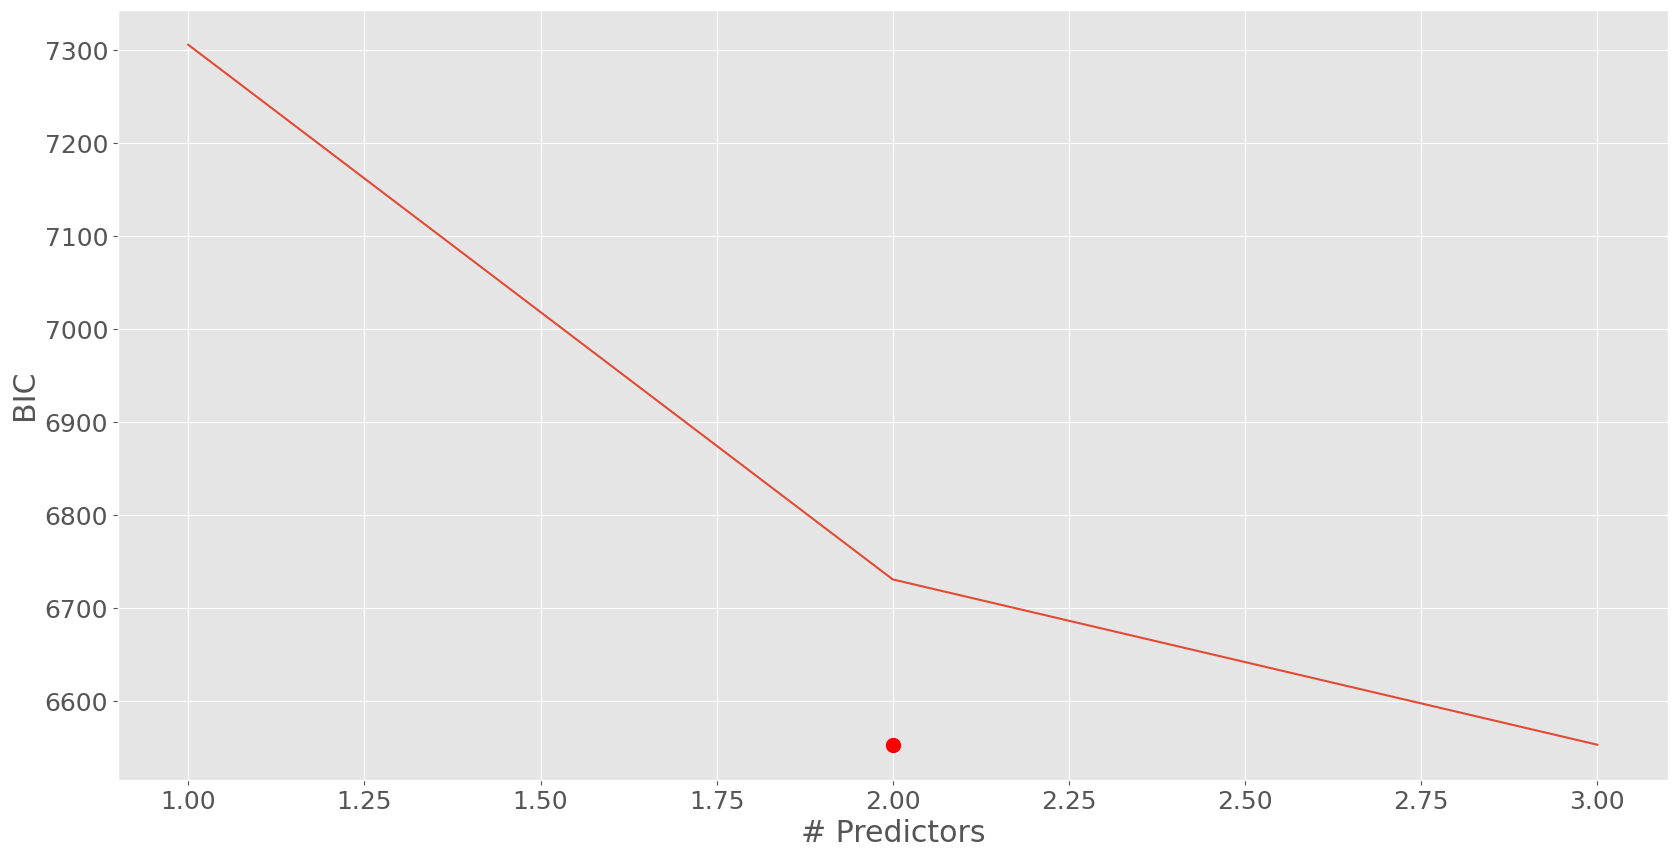

In [59]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

bic = models_best.apply(lambda row: row[2].bic, axis=1)

plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [60]:
X_optimal = X[["MonthlyCharges", "TotalCharges","Contract_Month-to-month"]]
X_train_optimal, X_test_optimal, y_train, y_test = train_test_split(X_optimal, y, test_size=0.3, random_state=42)
X_train_optimal_resampled, y_train_resampled = smote_enn.fit_resample(X_train_optimal, y_train)

In [61]:
results_optimal = {}

for model_name, model in models.items():
    model.fit(X_train_optimal_resampled, y_train_resampled)
    y_pred = model.predict(X_test_optimal)
    results_optimal[model_name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Balanced Accuracy': accuracy_score(y_test, y_pred)
    }

In [62]:
# Display the results
for model_name, metrics in results_optimal.items():
    print(f"Results for {model_name}:\n")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    print("\n")

Results for Decision Tree:

Precision: 0.463
Recall: 0.709
F1 Score: 0.561
ROC AUC: 0.706
Balanced Accuracy: 0.704


Results for Random Forest:

Precision: 0.487
Recall: 0.763
F1 Score: 0.595
ROC AUC: 0.736
Balanced Accuracy: 0.724


Results for Logistic Regression:

Precision: 0.478
Recall: 0.747
F1 Score: 0.583
ROC AUC: 0.726
Balanced Accuracy: 0.716


Results for XGBoost:

Precision: 0.479
Recall: 0.695
F1 Score: 0.567
ROC AUC: 0.710
Balanced Accuracy: 0.718


